In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('train.csv')

### Original distribution of our train dtaset

<b>Original</b>: Original BBC New's article <br>
<b>LLM generated</b>: phi2, gpt, mistral7b

In [3]:
train['dataset-origin'].value_counts()

phi2         417
gpt          417
mistral7b    417
original     417
Name: dataset-origin, dtype: int64

Text(0.5, 1.0, 'Word count distribution for Phi2')

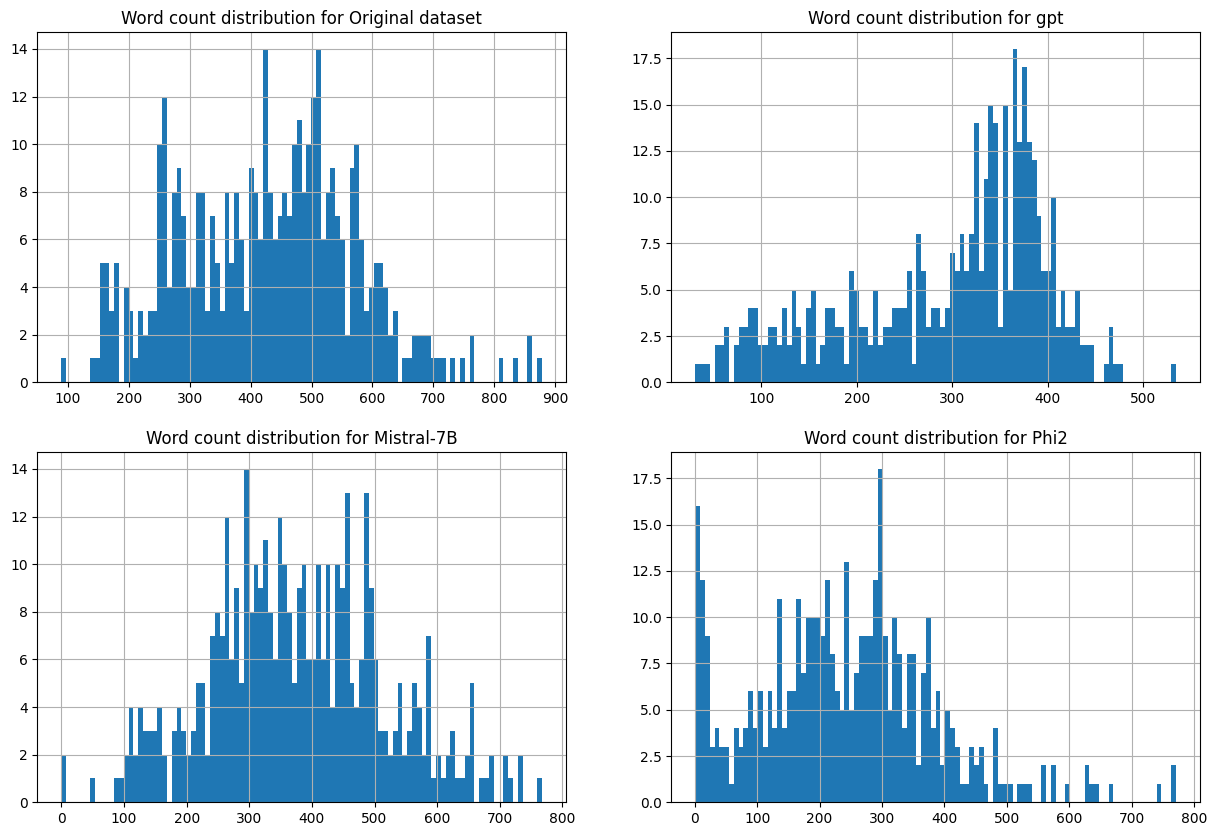

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
train[(train['dataset-origin'] == 'original') & (train['no_words'] < 900)]['no_words'].hist(bins=100)
plt.title('Word count distribution for Original dataset')

plt.subplot(2,2,2)
train[train['dataset-origin'] == 'gpt']['no_words'].hist(bins=100)
plt.title('Word count distribution for gpt')

plt.subplot(2,2,3)
train[train['dataset-origin'] == 'mistral7b']['no_words'].hist(bins=100)
plt.title('Word count distribution for Mistral-7B')

plt.subplot(2,2,4)
train[train['dataset-origin'] == 'phi2']['no_words'].hist(bins=100)
plt.title('Word count distribution for Phi2')

In [5]:
train['text'] = train['text'].astype(str)
lowest_word_count_from_original = train[train['dataset-origin'] == 'original']['no_words'].min()
train = train[train['no_words'] >= lowest_word_count_from_original].reset_index(drop=True) # set to filter samples with >= 89 word count to be align with the lowest word count of the original real samples

X = train['text']
y = train['label']
train['kfold'] = -1
print(f"Lowest word count from original Real samples: {lowest_word_count_from_original}")

Lowest word count from original Real samples: 89


### Perform K-fold split for cross-validation

This split the original train set into 10 different folds for training and validation

In [6]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

fold_no = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train.loc[test_index, 'kfold'] = fold_no
    fold_no += 1

In [7]:
kfold_label_counts = train.groupby('kfold')['label'].value_counts().unstack(fill_value=0)

formatted_counts = pd.DataFrame([
{
    'Kfold': kfold,
    'Label': ', '.join(f"{label}: {count}" for label, count in row.items())
}
for kfold, row in kfold_label_counts.iterrows()
])
formatted_counts

,Kfold,Label
0,0,"0: 42, 1: 117"
1,1,"0: 41, 1: 117"
2,2,"0: 41, 1: 117"
3,3,"0: 41, 1: 117"
4,4,"0: 42, 1: 116"
5,5,"0: 42, 1: 116"
6,6,"0: 42, 1: 116"
7,7,"0: 42, 1: 116"
8,8,"0: 42, 1: 116"
9,9,"0: 42, 1: 116"


### Train Customer BPE Tokenizer

Using a Max vocabulary of size 30000.

In [8]:
from tqdm import tqdm
from transformers import PreTrainedTokenizerFast
from tokenizers import (
    trainers,
    models,
    normalizers,
    pre_tokenizers,
    Tokenizer,
)
from datasets import Dataset

In [9]:
LOWERCASE = False
VOCAB_SIZE = 30000

# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
# Creating huggingface dataset object
dataset = Dataset.from_pandas(train[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_train = []

for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1581/1581 [00:01<00:00, 1228.86it/s]


### Fit TFIDF on the BPE tokens to generate a vocabulary of ngram_range=(1,2)

In [10]:
def pass_text(text):
    return text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, sublinear_tf=True, analyzer = 'word', tokenizer=pass_text, preprocessor=pass_text, token_pattern=None,
                             strip_accents='unicode')
vectorizer.fit(tokenized_texts_train)

TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                preprocessor=<function pass_text at 0x7f0eb3b78e50>,
                strip_accents='unicode', sublinear_tf=True, token_pattern=None,
                tokenizer=<function pass_text at 0x7f0eb3b78e50>)

In [11]:
vocab = vectorizer.vocabulary_

In [12]:
vocab.__len__()

212373

### Final data distribution after cleaning, filtering.

Original: 417 <br>
mistral7b: 414<br>
gpt: 398<br>
phi2: 352 

In [13]:
train['dataset-origin'].value_counts()

original     417
mistral7b    414
gpt          398
phi2         352
Name: dataset-origin, dtype: int64

### Label distribution for our training set.

<b>0</b>: Original Real BBC New's article <br>
<b>1</b>: Generated LLM content from mistral7b, gpt, and phi2

In [14]:
train['label'].value_counts()

1    1164
0     417
Name: label, dtype: int64

In [15]:
train[train['kfold'] != 0]['label'].value_counts()

1    1047
0     375
Name: label, dtype: int64

### Tokenize the text using our BPE tokenizer

This is a sparse matrix with (N_samples X N_tokens) where N_tokens is bounded by the 30,000 vocabulary size we defined when training the BPE tokenizer.

In [17]:
vectorizer_2 = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, sublinear_tf=True, analyzer = 'word',
                               vocabulary=vocab,
                               tokenizer=pass_text, preprocessor=pass_text, token_pattern=None,
                             strip_accents='unicode')
tf_train = vectorizer_2.fit_transform(tokenized_texts_train)

In [18]:
test_preds_list = []
test_preds_prob_list = []
y_val_list = []
y_preds_list = []
val_df = []
val_index_list = []
for i in range(10):
    train_index = train[train['kfold'] != i].index.values
    val_index = train[train['kfold'] == i].index.values
    
    X_train = tf_train[train_index]
    y_train = train.iloc[train_index]['label']
    
    X_val = tf_train[val_index]
    y_val = train.iloc[val_index]['label']
    
    num_negatives = sum(y_train == 0)
    num_positives = sum(y_train == 1)
    scale_pos_weight = num_positives / num_negatives
    
    weights = np.where(y_train == 0, scale_pos_weight, 1)

    dtrain = lgb.Dataset(X_train, label=y_train.values, weight=weights)
    dvalid = lgb.Dataset(X_val, label=y_val.values)    

    params =    {'lambda_l1': 0.2e-4, 'lambda_l2': 3e-5, 'num_leaves': 3,
                 'feature_fraction': 0.4, 'bagging_fraction': 0.6, 'bagging_freq': 3,
                 'min_child_samples': 7, 'learning_rate': 0.01, 'n_estimators': 20,
                  'num_class': 1,
                'objective': 'binary',
                'metric': ['binary_logloss', 'auc'],
                'boosting_type': 'gbdt',
                'scale_pos_weight': scale_pos_weight,
        }
    model = lgb.train(params, dtrain, valid_sets=[dvalid], verbose_eval=-1,
                         callbacks=[
                             lgb.early_stopping(stopping_rounds=30, verbose=False),
                         ])

    preds = model.predict(X_val, num_iteration=model.best_iteration)
    
    y_val_list.append(y_val.values)
    y_preds_list.append(preds)
    score = roc_auc_score(y_val, preds)
    print(score)
    val_df.append(train[train.index.isin(val_index)])
    val_index_list.append(val_index)
    # break

y_preds_list = np.hstack(y_preds_list)
y_val_list = np.hstack(y_val_list)

/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1047, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202330
[LightGBM] [Info] Number of data points in the train set: 1422, number of used features: 16908
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9922669922669922


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1047, number of negative: 376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202858
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 16923
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9677923702313946


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1047, number of negative: 376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204386
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 17086
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9805086512403586


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1047, number of negative: 376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202066
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 16802
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9987492182614134


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1048, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204960
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 17065
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9963054187192119


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1048, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204422
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 17075
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9963054187192119


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1048, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203977
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 16992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9880952380952381


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1048, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202569
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 16909
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9951765188834154


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1048, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201912
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 16817
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9911740558292282


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1048, number of negative: 375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202864
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 16909
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.983784893267652


### Using probability thresholds of >= 0.5 for Fake Article

In [19]:
val_df_cv = pd.concat(val_df)
val_df_cv['preds'] = np.where(y_preds_list >= .5, 1, 0)

### ROC AUC Score

In [20]:
roc_auc_score(y_val_list, y_preds_list)

0.9887564175463752

### Confusion Matrix

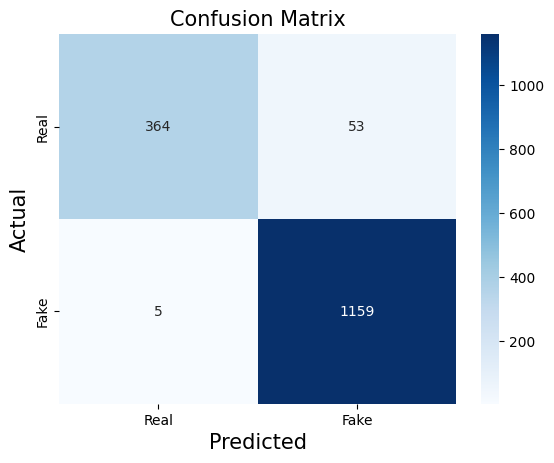

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(val_df_cv['label'].values, val_df_cv['preds'].values)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted", size=15)
plt.ylabel("Actual", size=15)
plt.title("Confusion Matrix", size=15)
plt.show()

In [22]:
y_true = val_df_cv['label'].values
y_pred = val_df_cv['preds'].values

In [23]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, labels=[0,1],average=None)
recall = recall_score(y_true, y_pred, labels=[0,1], average=None)

print("Precision for each class:", precision)  # Precision for class 0 and class 1
print("Recall for each class:", recall)  # Recall for class 0 and class 1

Precision for each class: [0.98644986 0.95627063]
Recall for each class: [0.87290168 0.99570447]


In [24]:
### Analysis of the misclassified samples
# val_df_cv[val_df_cv['label'] != val_df_cv['preds']]

In [25]:
# val_df_cv[val_df_cv['label'] != val_df_cv['preds']].iloc[-21]['text']
# val_df_cv[val_df_cv['label'] != val_df_cv['preds']].iloc[4]['text']

### ROC AUC Curve

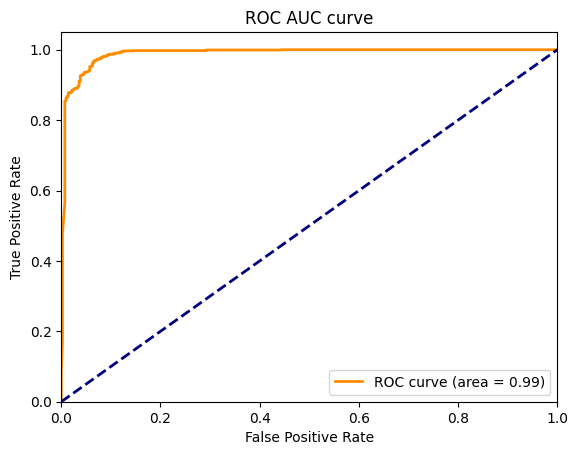

In [26]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val_list, y_preds_list)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC curve')
plt.legend(loc="lower right")
plt.show()